In [ ]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm pyqt5 pyqtwebengine ruamel-yaml lxml wikipedia-api matplotlib xlsxwriter

In [3]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from urllib.request import urlopen
import json
import wikipediaapi
import difflib
import matplotlib.pyplot as plt
from datetime import datetime
import mwparserfromhell
import xlsxwriter
import os
from html import unescape

#### Retrieving names of up-to-date sections in an article

In [5]:
# Create a custom user-agent string
headers = {
    'User-Agent': 'YourAppName/1.0 (berenis0102@gmail.com)'  # Replace with your e-mail
}

# Initialize the Wikipedia API with a custom user-agent
wiki = wikipediaapi.Wikipedia(
    'en',  # 'en' for English Wikipedia
    headers=headers
)

# Get the page object for the article
page = wiki.page('Opioid epidemic in the United States')  # Replace with the article title

# Function to recursively list sections
def print_sections(sections, level=0):
    for section in sections:
        print("%s: %s" % ("*" * (level + 1), section.title))
        print_sections(section.sections, level + 1)

# Print the "(Top)" summary as a separate entry
print("* (Top): Summary")
#print(page.summary)  # Print the summary content

# List sections of the page
print_sections(page.sections)

* (Top): Summary
*: Background
*: Waves of the opioid epidemic
**: First wave
**: Second wave
**: Third wave
**: Fourth wave
**: Causes
*: History
**: Heroin
**: Oxycodone
**: Hydrocodone
**: Codeine
**: 2010s to present (increase in fentanyl)
*: Demographics
**: Race
**: Sex
**: Age
**: Economic status
**: Geography
*: Impact
**: Treatment and effects during COVID-19 pandemic
*: Countermeasures
**: US federal government
**: State and local governments
**: Economic impact
**: Legal action
***: Ohio jury trial
***: States reject distributors' settlement
***: July 2021 settlement
***: Cleveland Settlement
**: Homicide by overdose
**: Prescription drug monitoring
**: In the media
***: DEA Data
**: Treatment
***: Methadone
***: Buprenorphine
***: Behavioral treatment
**: Harm reduction
***: Increasing Bystander Intervention
***: Naloxone
***: Overdose prevention centers
***: Needle exchange programs
***: Use of blue lights
**: Pill mill
**: Trafficking
*: See also
*: References


# Checking which sections were edited and how many times
## (if a section has subsections, their edits are included in the section's edit count)

In [ ]:
# Define the MediaWiki API URL
url = "https://en.wikipedia.org/w/api.php"

def extract_sections_with_content(wikitext):
    sections = []
    content = []
    section_stack = []
    has_first_section = False  # Flag to check if any section headers have been found

    # Split the wikitext into lines
    lines = wikitext.split('\n')
    for line in lines:
        # Match section headers (== section title ==)
        section_match = re.match(r"^(=+)\s*(.*?)\s*\1\s*$", line)
        if section_match:
            # Save the previous content as a section
            if not has_first_section and content:
                # Content before the first section header
                sections.append({
                    'title': '(Top)',
                    'content': '\n'.join(content).strip(),
                    'level': 0,
                })
                content = []
            elif section_stack:
                full_title = ' > '.join([s['title'] for s in section_stack])
                sections.append({
                    'title': full_title,
                    'content': '\n'.join(content).strip(),
                    'level': section_stack[-1]['level'],
                })
                content = []
            # Start a new section
            level = len(section_match.group(1)) - 1
            title = section_match.group(2).strip()
            # Adjust the section stack based on the level
            while section_stack and section_stack[-1]['level'] >= level:
                section_stack.pop()
            section_stack.append({'title': title, 'level': level})
            has_first_section = True
        else:
            content.append(line)
    # Save the last section if any
    if section_stack:
        full_title = ' > '.join([s['title'] for s in section_stack])
        sections.append({
            'title': full_title,
            'content': '\n'.join(content).strip(),
            'level': section_stack[-1]['level'],
        })
    elif content:
        # If there are content lines but no section headers, treat as (Top)
        sections.append({
            'title': '(Top)',
            'content': '\n'.join(content).strip(),
            'level': 0,
        })
    return sections

def wikitext_to_plain_text(wikitext):
    plain_text = re.sub(r"\[\[.*?\|", "", wikitext)
    plain_text = re.sub(r"\[\[|\]\]", "", plain_text)
    plain_text = re.sub(r"'{2,}", "", plain_text)
    plain_text = re.sub(r"<.*?>.*?</.*?>", "", plain_text)
    plain_text = re.sub(r"<.*?/>", "", plain_text)
    plain_text = re.sub(r"\{\{.*?\}\}", "", plain_text)
    plain_text = re.sub(r"={2,}.*?={2,}", "", plain_text)
    plain_text = re.sub(r"\[http[^\]]*\]", "", plain_text)
    plain_text = re.sub(r"\n+", "\n", plain_text)
    return unescape(plain_text.strip())

def normalize_content(content):
    # Remove non-content elements and whitespace
    normalized = wikitext_to_plain_text(content)
    normalized = re.sub(r'\s+', ' ', normalized)  # Replace multiple spaces with a single space
    return normalized.strip()

def get_section_edit_history(page_title):
    try:
        # First, try to get the page ID to check if the page exists
        page_info_params = {
            "action": "query",
            "format": "json",
            "titles": page_title,
        }
        page_info_response = requests.get(url, params=page_info_params)
        page_info_response.raise_for_status()
        page_info_data = page_info_response.json()
        pages = page_info_data['query']['pages']
        page_id = next(iter(pages))
        if page_id == "-1":
            print(f"Page '{page_title}' does not exist. Check the spelling - the page title should correspond to its name in Wikipedia.")
            return None, None
        normalized_title = pages[page_id]['title']
        print(f"Fetching revisions for page: {normalized_title}. Please wait")

        # Now proceed to fetch revisions using the normalized title
        params = {
            "action": "query",
            "format": "json",
            "prop": "revisions",
            "titles": normalized_title,
            "rvprop": "ids|timestamp|user|content",
            "rvslots": "main",
            "rvlimit": "max",
            "rvdir": "newer"
        }

        section_history = []
        section_levels = {}
        previous_combined_contents = {}
        continuation = True
        all_revisions = []
        all_section_titles = set()  # Collect all unique section titles

        while continuation:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()

            if 'error' in data:
                print(f"API Error: {data['error']['info']}")
                return None, None

            pages = data['query']['pages']
            page_id = next(iter(pages))
            revisions = pages[page_id].get('revisions', [])

            if not revisions:
                print("No revisions found for this page.")
                return None, None

            all_revisions.extend(revisions)

            if 'continue' in data:
                params.update(data['continue'])
            else:
                continuation = False

        if not all_revisions:
            print("No revisions found for this page.")
            return None, None

        # Collect all unique section titles from all revisions
        for rev in all_revisions:
            try:
                content = rev.get('slots', {}).get('main', {}).get('*', "")
                if not content:
                    print(f"Skipping revision {rev['revid']} with no content.")
                    continue

                sections = extract_sections_with_content(content)
                for section in sections:
                    title = section['title']
                    level = section['level']
                    all_section_titles.add(title)
                    section_levels[title] = level  # Keep the latest level found
            except Exception as e:
                print(f"Error while extracting sections from revision {rev['revid']}: {e}")
                continue

        # Initialize edit_counts for all sections found in any revision
        edit_counts = {title: 0 for title in all_section_titles}

        # Initialize previous_combined_contents for all sections
        previous_combined_contents = {title: "" for title in all_section_titles}

        # Process revisions in order
        for rev in all_revisions:
            try:
                rev_id = rev['revid']
                timestamp = rev['timestamp']
                user = rev.get('user', 'Anonymous/Bot')
                slots = rev.get('slots', {})
                main_slot = slots.get('main', {})
                content = main_slot.get('*')

                if not content:
                    print(f"No content found for Revision ID={rev_id}. Skipping.")
                    continue

                sections = extract_sections_with_content(content)
                combined_contents = {}

                # Build combined contents for each section including subsections
                for idx, section in enumerate(sections):
                    title = section['title']
                    level = section['level']
                    section_levels[title] = level  # Store the level

                    combined_content = section['content']
                    current_level = level
                    for sub_idx in range(idx + 1, len(sections)):
                        sub_section = sections[sub_idx]
                        sub_level = sub_section['level']
                        if sub_level > current_level:
                            combined_content += "\n" + sub_section['content']
                        else:
                            break
                    combined_contents[title] = combined_content

                # Compare with previous combined contents
                for title in all_section_titles:
                    content = combined_contents.get(title, "")
                    normalized_current = normalize_content(content)
                    normalized_previous = normalize_content(previous_combined_contents.get(title, ""))

                    if normalized_current != normalized_previous:
                        # Content has changed
                        edit_counts[title] += 1
                        section_history.append({
                            'Section': title,
                            'Level': '*' * max(0, section_levels.get(title, 0)),
                            'Revision ID': rev_id,
                            'Timestamp': timestamp,
                            'User': user,
                            'Content': content
                        })

                    # Update previous_combined_contents
                    previous_combined_contents[title] = content

            except Exception as e:
                print(f"Error processing revision ID={rev['revid']}: {e}")
                continue

        # Build summary_df including the Level marks
        summary_data = []
        for title, count in edit_counts.items():
            level_marks = '*' * max(0, section_levels.get(title, 0))  # Ensure level is non-negative
            summary_data.append({'Section': title, 'Level': level_marks, 'Edit Count': count})

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values(by=['Edit Count'], ascending=False)

        section_history_df = pd.DataFrame(section_history)

        print("\nSummary of Section Edit Counts:")
        print(summary_df.to_string(index=False))

        return summary_df, section_history_df

    except requests.exceptions.RequestException as e:
        print(f"Network error occurred: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

def save_files(article_name, summary_df, section_history_df, save_as='both'):
    datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
    safe_article_name = re.sub(r'[\\/*?:"<>|]', "_", article_name)
    summary_filename = f"{safe_article_name}_summary_{datetime_str}"
    history_filename = f"{safe_article_name}_{datetime_str}"

    if save_as in ['both', 'excel']:
        summary_df.to_excel(f"{summary_filename}.xlsx", index=False)
        section_history_df.to_excel(f"{history_filename}.xlsx", index=False)
        print(f"\nSummary saved to {summary_filename}.xlsx")
        print(f"Detailed section history saved to {history_filename}.xlsx")
    
    if save_as in ['both', 'csv']:
        summary_df.to_csv(f"{summary_filename}.csv", index=False)
        section_history_df.to_csv(f"{history_filename}.csv", index=False)
        print(f"\nSummary saved to {summary_filename}.csv")
        print(f"Detailed section history saved to {history_filename}.csv")

# Example usage:
page_title = 'Opioid epidemic in the United States'  # Replace with the page title

result = get_section_edit_history(page_title)
if result is not None:
    summary_df, section_history_df = result
else:
    print("Failed to retrieve section edit history.")

### Saving the files (summary and a detailed table with edits information)

In [ ]:
save_files(page_title, summary_df, section_history_df, save_as='excel')  # Options: 'excel', 'csv', 'both'

# Printing and saving the dataframe with the number of edits by year
## (To be executed properly, run this code only after running the previous chunk "Checking which sections were edited and how many times")

In [ ]:
# Define the article name (use the Wikipedia page title, or any string you want for the file names)
article_name = 'Opioid-induced hyperalgesia'  # Replace this with your actual article name

# Chunk to print and optionally save the DataFrame for the whole article (pivoted by year, including Level)
def print_and_save_df_for_article(save_as='none'):
    # Extract the year from the Timestamp column
    section_history_df['Year'] = pd.to_datetime(section_history_df['Timestamp']).dt.year
    
    # Pivot table by Section and Level, with year columns
    pivot_df = section_history_df.pivot_table(
        index=['Section', 'Level'], 
        columns='Year', 
        aggfunc='size', 
        fill_value=0
    )
    
    # Convert the pivot_df to object dtype to allow mixed data types
    pivot_df = pivot_df.astype(object)
    
    # Identify the first year each section appears
    first_years = section_history_df.groupby(['Section', 'Level'])['Year'].min()
    
    # Update pivot_df to replace 0 with 'N/A' for years before the section's first appearance
    for (section, level), first_year in first_years.items():
        # Select the range of years before the section first appeared
        before_first_year = pivot_df.columns[pivot_df.columns < first_year]
        
        # Update these values to 'N/A' for the specified section and level
        pivot_df.loc[(section, level), before_first_year] = 'N/A'
    
    # Ensure all unique sections from all revisions are included in the pivot_df, even those not currently in section_history_df
    all_unique_sections = set([(row['Section'], row['Level']) for row in section_history_df.to_dict('records')])
    for section in all_unique_sections:
        if section not in pivot_df.index:
            # Add missing section rows with all values as 'N/A'
            pivot_df.loc[section] = ['N/A'] * len(pivot_df.columns)
    
    # Print the pivot table to check the result
    print("\nData used for the plot (pivoted by year for the whole article, including Level with N/A for non-existing years):")
    print(pivot_df)
    
    # Saving options
    if save_as in ['csv', 'excel', 'both']:
        datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
        safe_article_name = re.sub(r'[\\/*?:"<>|]', "_", article_name)
        filename = f"edits_per_year_{safe_article_name}_{datetime_str}"
        
        if save_as in ['csv', 'both']:
            pivot_df.to_csv(f"{filename}.csv")
            print(f"Data saved to {filename}.csv")
        
        if save_as in ['excel', 'both']:
            pivot_df.to_excel(f"{filename}.xlsx")
            print(f"Data saved to {filename}.xlsx")

# Call this function for the whole article (optionally save the result)
print_and_save_df_for_article(save_as='excel')  # 'csv', 'excel', or 'none' can also be used

# Plotting the timeline of revisions 

## Plotting the timeline for the whole article

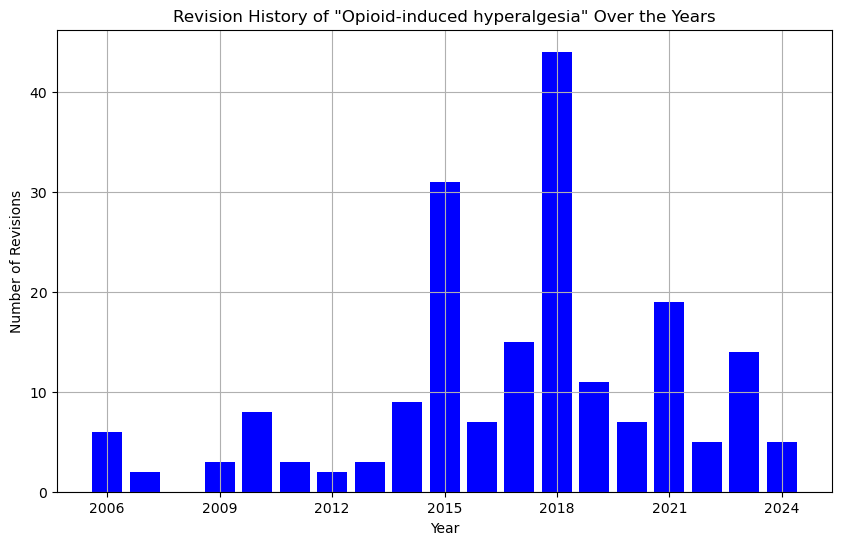

In [15]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define the MediaWiki API URL
api_url = "https://en.wikipedia.org/w/api.php"

# Function to get all revisions of a Wikipedia page
def get_page_revision_history(article_title):
    # Initialize API request parameters
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": article_title,
        "rvprop": "ids|timestamp|user|content",
        "rvlimit": "max",
        "rvslots": "main",
        "rvdir": "newer"  # Get revisions starting from the oldest
    }

    page_revisions = []  # List to store revision data
    continuation = True  # Pagination control variable

    while continuation:
        # Make the API request
        response = requests.get(api_url, params=params)
        response.raise_for_status()  # Ensure we handle HTTP errors gracefully
        data = response.json()

        # Extract the page content and revisions
        pages = data['query']['pages']
        page_id = list(pages.keys())[0]
        revisions = pages[page_id].get('revisions', [])

        # If no revisions are found, stop the process
        if not revisions:
            print(f"No revisions found for page: {article_title}")
            return []

        # Append revisions to the list
        for rev in revisions:
            rev_info = {
                'Revision ID': rev['revid'],
                'Timestamp': rev['timestamp'],
                'User': rev.get('user', 'Anonymous/Bot'),  # Handle missing 'user' field
                'Content': rev.get('slots', {}).get('main', {}).get('*', '')  # Retrieve content for (Top)
            }
            page_revisions.append(rev_info)

        # Handle continuation (pagination) for large datasets
        if 'continue' in data:
            params.update(data['continue'])
        else:
            continuation = False

    return page_revisions

# Function to plot the number of revisions over the years
def plot_page_revision_history(revision_history, page_title):
    # Convert the revision data to a DataFrame
    rev_df = pd.DataFrame(revision_history)
    
    # Convert the 'Timestamp' to datetime
    rev_df['Timestamp'] = pd.to_datetime(rev_df['Timestamp'])
    
    # Extract the year from the timestamp
    rev_df['Year'] = rev_df['Timestamp'].dt.year
    
    # Group by year and count the number of revisions
    yearly_revision_counts = rev_df.groupby('Year').size()
    
    # Plot the number of revisions per year
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(yearly_revision_counts.index, yearly_revision_counts.values, color='b')
    ax.set_title(f'Revision History of "{page_title}" Over the Years')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Revisions')
    ax.grid(True)

    # Set x-axis ticks to display every N years (e.g., every 3 years)
    step = 3  # Modify this value based on how often you want the ticks
    ax.set_xticks(range(int(min(yearly_revision_counts.index)), int(max(yearly_revision_counts.index)) + 1, step))

    # Return the figure for saving without showing it yet
    return fig

# Example usage
page_title = 'Opioid-induced hyperalgesia'  # Replace with the Wikipedia article you want
revision_history = get_page_revision_history(page_title)

if revision_history:
    fig = plot_page_revision_history(revision_history, page_title)

    plt.show()
else:
    print("No revision history data to plot.")

#### Saving the timeline plot for the whole article

In [ ]:
def save_plot_as_png(fig, page_title):
    # Prepare the filename based on the page title and datetime
    datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
    filename = f"{page_title}_plot_{datetime_str}.png"
    
    # Save the plot as a PNG file
    fig.savefig(filename)
    print(f"Plot saved as {filename}")

# Example usage for saving the plot
save_plot_as_png(fig, page_title)

## Plotting the timeline for the chosen section

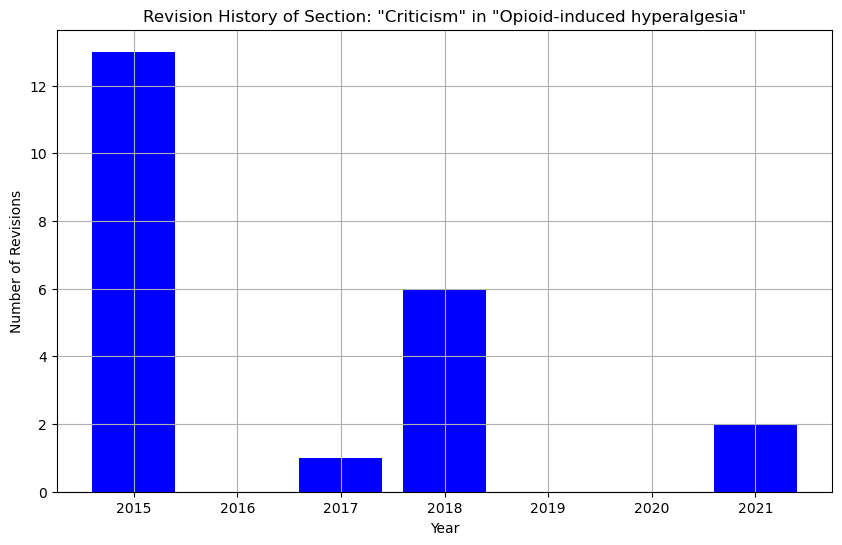

In [19]:
# Define the API URL
api_url = "https://en.wikipedia.org/w/api.php"

def extract_sections_with_content(wikitext):
    sections = []
    content = []
    section_stack = []

    # Split the wikitext into lines
    lines = wikitext.split('\n')
    for line in lines:
        # Match section headers (== section title ==)
        section_match = re.match(r"^(=+)\s*(.*?)\s*\1\s*$", line)
        if section_match:
            # Save the previous section and its content
            if section_stack:
                full_title = ' > '.join([s['title'] for s in section_stack])
                sections.append({
                    'title': full_title,
                    'content': '\n'.join(content).strip(),
                    'level': section_stack[-1]['level'],
                })
            # Start a new section
            level = len(section_match.group(1)) - 1
            title = section_match.group(2).strip()
            # Adjust the section stack based on the level
            while section_stack and section_stack[-1]['level'] >= level:
                section_stack.pop()
            section_stack.append({'title': title, 'level': level})
            content = []
        else:
            content.append(line)
    # Save the last section if any
    if section_stack:
        full_title = ' > '.join([s['title'] for s in section_stack])
        sections.append({
            'title': full_title,
            'content': '\n'.join(content).strip(),
            'level': section_stack[-1]['level'],
        })
    return sections

def wikitext_to_plain_text(wikitext):
    plain_text = re.sub(r"\[\[.*?\|", "", wikitext)
    plain_text = re.sub(r"\[\[|\]\]", "", plain_text)
    plain_text = re.sub(r"'{2,}", "", plain_text)
    plain_text = re.sub(r"<.*?>.*?</.*?>", "", plain_text)
    plain_text = re.sub(r"<.*?/>", "", plain_text)
    plain_text = re.sub(r"\{\{.*?\}\}", "", plain_text)
    plain_text = re.sub(r"={2,}.*?={2,}", "", plain_text)
    plain_text = re.sub(r"\[http[^\]]*\]", "", plain_text)
    plain_text = re.sub(r"\n+", " ", plain_text)
    return unescape(plain_text.strip())

def normalize_content(content):
    return wikitext_to_plain_text(content).replace(" ", "").replace("\n", "").strip()

def get_section_edit_history(page_title, section_name):
    # Initialize API request parameters
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": "ids|timestamp|user|content",
        "rvslots": "main",
        "rvlimit": "max",
        "rvdir": "newer"  # Get revisions starting from the oldest
    }

    section_history = []
    previous_content = ""
    continuation = True

    target_full_title = None  # We'll set this when we first find the section
    section_found = False

    while continuation:
        response = requests.get(api_url, params=params)
        data = response.json()

        pages = data['query']['pages']
        page_id = list(pages.keys())[0]
        revisions = pages[page_id].get('revisions', [])

        if not revisions:
            return section_history

        for rev in revisions:
            rev_id = rev['revid']
            timestamp = rev['timestamp']
            user = rev.get('user', 'Anonymous/Bot')
            slots = rev.get('slots', {})
            main_slot = slots.get('main', {})
            content = main_slot.get('*')

            if content:
                sections = extract_sections_with_content(content)
                # Collect section titles
                section_titles = [section['title'] for section in sections]
                # Try to find the target section in the current revision
                matching_titles = [title for title in section_titles if title.endswith(section_name)]

                if matching_titles:
                    if not target_full_title:
                        # Set target_full_title when we first find the section
                        target_full_title = matching_titles[0]
                        section_found = True

                if target_full_title:
                    # Now we can proceed to extract the section content
                    target_content = None
                    for section in sections:
                        if section['title'] == target_full_title:
                            target_content = section['content']
                            break
                    if target_content is not None:
                        normalized_current_content = normalize_content(target_content)
                        normalized_previous_content = normalize_content(previous_content)

                        if normalized_current_content != normalized_previous_content:
                            section_history.append({
                                'Revision ID': rev_id,
                                'Timestamp': timestamp,
                                'User': user,
                                'Content': target_content
                            })
                            previous_content = target_content
                    else:
                        # The section does not exist in this revision
                        normalized_current_content = ""
                        normalized_previous_content = normalize_content(previous_content)
                        if normalized_current_content != normalized_previous_content:
                            # Section was removed
                            section_history.append({
                                'Revision ID': rev_id,
                                'Timestamp': timestamp,
                                'User': user,
                                'Content': ""
                            })
                            previous_content = ""
        if 'continue' in data:
            params.update(data['continue'])
        else:
            continuation = False

    if not section_found:
        print(f"Section '{section_name}' not found in any revision.")
        return []

    return section_history

def plot_revision_history(section_history, section_name, page_title):
    if not section_history:
        print(f"No revisions found for the section: {section_name}")
        return None

    section_df = pd.DataFrame(section_history)
    section_df['Timestamp'] = pd.to_datetime(section_df['Timestamp'])
    section_df['Year'] = section_df['Timestamp'].dt.year
    revision_counts = section_df.groupby('Year').size()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(revision_counts.index, revision_counts.values, color='b')
    ax.set_title(f'Revision History of Section: "{section_name}" in "{page_title}"')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Revisions')
    ax.grid(True)

    plt.show()
    return fig

def save_section_plot_as_png(fig, page_title, section_name):
    datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
    filename = f"{page_title.replace(' ', '_')}_{section_name.replace(' ', '_')}_plot_{datetime_str}.png"
    fig.savefig(filename)
    print(f"Plot saved as {filename}")

# Example usage
page_title = 'Opioid-induced hyperalgesia'
section_name = 'Criticism'  # Replace with the section you're interested in
section_history = get_section_edit_history(page_title, section_name)

if section_history:
    fig = plot_revision_history(section_history, section_name, page_title)
else:
    print("No section history to display.")

#### Saving the timeline plot for the chosen section

In [ ]:
if fig:
    save_section_plot_as_png(fig, page_title, section_name)

# Retrieving content of a particular section

## Getting all the past and present names of the page's sections and subsections in alphabetical order

In [39]:
import requests
import re
from html import unescape

# Function to extract sections from wikitext, including hierarchical paths
def extract_sections(wikitext):
    sections = []
    lines = wikitext.split('\n')
    section_stack = []
    top_content_detected = False  # Flag to detect if there's content before the first header

    # Iterate through lines to detect sections
    for line in lines:
        # Match section headers (== section title ==)
        section_match = re.match(r"^(=+)\s*(.*?)\s*\1\s*$", line)
        if section_match:
            level = len(section_match.group(1)) - 1  # Level starts from 1
            title = section_match.group(2).strip()

            # Adjust the section stack based on the level
            while section_stack and section_stack[-1]['level'] >= level:
                section_stack.pop()
            section_stack.append({'title': title, 'level': level})

            # Build full section path
            full_title = ' > '.join([s['title'] for s in section_stack])
            sections.append(full_title)
        elif not top_content_detected and line.strip():
            # If there is non-empty content before the first header, mark "(Top)"
            top_content_detected = True

    # Add "(Top)" section if it has been detected
    if top_content_detected:
        sections.insert(0, "(Top)")

    return sections

# Function to get all past names of sections/subsections
def get_past_section_names(page_title, specific_section_name=None):
    # Define the MediaWiki API URL
    api_url = "https://en.wikipedia.org/w/api.php"

    # Initialize params for the API request
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": "ids|timestamp|user|content",
        "rvslots": "main",
        "rvlimit": "max",
        "rvdir": "newer"  # Start from the oldest revisions
    }

    # Data structure to hold section name history
    section_names = set()  # Use a set to avoid duplicates

    # Initialize continuation
    continuation = True

    section_found = False  # Flag to check if the specific section is found

    while continuation:
        response = requests.get(api_url, params=params)
        data = response.json()

        # Extract the page content and revisions
        pages = data['query']['pages']
        page_id = list(pages.keys())[0]  # Get the first page id
        revisions = pages[page_id].get('revisions', [])

        # Iterate over the revisions and extract sections
        for rev in revisions:
            slots = rev.get('slots', {})
            main_slot = slots.get('main', {})
            content = main_slot.get('*')  # Get the wikitext content

            if content:
                # Extract sections, including "(Top)" if applicable
                sections = extract_sections(content)
                section_names.update(sections)

                # Check if the specific section is found
                if specific_section_name:
                    for section in sections:
                        if section.endswith(specific_section_name):
                            section_found = True

        # Handle continuation (pagination)
        if 'continue' in data:
            params.update(data['continue'])
        else:
            continuation = False

    if specific_section_name and not section_found:
        print("Section not found. Check the spelling")

    return sorted(list(section_names))  # Sort alphabetically

# Example usage:
page_title = 'Opioid-induced hyperalgesia'  # Replace with your page title
specific_section_name = 'Pharmacogenomics'  # Replace with the specific section name you're interested in
all_section_names = get_past_section_names(page_title, specific_section_name)

print(f"All section names throughout the history of '{page_title}' (in alphabetical order):")
for name in all_section_names:
    print(name)

All section names throughout the history of 'Opioid-induced hyperalgesia' (in alphabetical order):
(Top)
Criticism
Differentiation from tolerance
Management
Mechanism of Action
Mechanism of action
Mechanism of action > Long-Term Potentiation
Mechanism of action > NMDA Receptors
Mechanism of action > μ-opioid receptors
Pharmacogenomics
Pharmacology
References
Research needs
See also


# Getting the revision history of a section by its name. The first 3 results are printed.
### You can save the whole output as a file in the next chunk. 

In [ ]:
# Function to extract sections and their content from wikitext, including hierarchical paths
def extract_sections_with_content(wikitext):
    sections = []
    content = []
    section_stack = []
    has_first_section = False  # Flag to check if any section headers have been found

    # Split the wikitext into lines
    lines = wikitext.split('\n')
    for line in lines:
        # Match section headers (e.g., == Section ==)
        section_match = re.match(r"^(=+)\s*(.*?)\s*\1\s*$", line)
        if section_match:
            # Save the previous section and its content
            if section_stack:
                full_title = ' > '.join([s['title'] for s in section_stack])
                sections.append({
                    'title': full_title,
                    'content': '\n'.join(content).strip(),
                    'level': section_stack[-1]['level'],
                })
            # Start a new section
            level = len(section_match.group(1)) - 1  # Level starts from 1
            title = section_match.group(2).strip()
            # Adjust the section stack based on the level
            while section_stack and section_stack[-1]['level'] >= level:
                section_stack.pop()
            section_stack.append({'title': title, 'level': level})
            content = []
            has_first_section = True
        else:
            content.append(line)
    # Save the last section if any
    if section_stack:
        full_title = ' > '.join([s['title'] for s in section_stack])
        sections.append({
            'title': full_title,
            'content': '\n'.join(content).strip(),
            'level': section_stack[-1]['level'],
        })
    elif content:
        # If there is content but no sections, treat it as (Top)
        sections.append({
            'title': '(Top)',
            'content': '\n'.join(content).strip(),
            'level': 0,
        })
    return sections

# Improved function to strip wikitext format and convert to clean plain text
def wikitext_to_plain_text(wikitext):
    # Remove wiki formatting (e.g., [[link|text]], ''italics'', bold, etc.)
    plain_text = re.sub(r"\[\[(?:File|Image):.*?\]\]", "", wikitext)  # Remove images and files
    plain_text = re.sub(r"\[\[.*?\|(.*?)\]\]", r"\1", plain_text)  # Convert [[link|text]] to text
    plain_text = re.sub(r"\[\[|\]\]", "", plain_text)  # Remove remaining [[ and ]]
    plain_text = re.sub(r"'{2,}", "", plain_text)  # Remove '' or ''' used for italics or bold
    plain_text = re.sub(r"<.*?>.*?</.*?>", "", plain_text)  # Remove HTML tags like <ref>...</ref>
    plain_text = re.sub(r"<.*?/>", "", plain_text)  # Remove self-closing HTML tags
    plain_text = re.sub(r"\{\{.*?\}\}", "", plain_text)  # Remove templates
    plain_text = re.sub(r"={2,}.*?={2,}", "", plain_text)  # Remove section headers
    plain_text = re.sub(r"\[http[^\]]*\]", "", plain_text)  # Remove external links
    plain_text = re.sub(r"&nbsp;", " ", plain_text)  # Replace non-breaking spaces
    plain_text = re.sub(r"\n+", " ", plain_text)  # Replace multiple newlines with spaces
    plain_text = re.sub(r"\s+", " ", plain_text)  # Replace multiple spaces with a single space
    return unescape(plain_text.strip())

# Normalize content for comparison by stripping whitespace and wikitext formatting
def normalize_content(content):
    return wikitext_to_plain_text(content).replace(" ", "").replace("\n", "").strip()

# Modified function to retrieve revisions where the chosen section (and its subsections) changed
def get_section_versions_with_subsections(page_title, section_name):
    api_url = "https://en.wikipedia.org/w/api.php"

    # Initialize params for the API request to get revisions with content
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": "ids|timestamp|user|flags|comment|content",
        "rvslots": "main",
        "rvlimit": "max",
        "rvdir": "older"  # Fetch older revisions first
    }

    # Data structure to store relevant versions of the section
    section_versions = []

    # Initialize continuation
    continuation = True
    previous_version_content = ""  # Store content of the chosen section/subsections from the previous revision

    target_full_title = None  # We will set this when we first find the section
    section_found = False

    while continuation:
        response = requests.get(api_url, params=params)
        data = response.json()

        # Extract the page content and revisions
        pages = data['query']['pages']
        page_id = list(pages.keys())[0]  # Get the first page id
        revisions = pages[page_id].get('revisions', [])

        # Iterate over the revisions and extract sections
        for rev in revisions:
            rev_id = rev['revid']
            timestamp = rev['timestamp']
            user = rev.get('user', 'Anonymous/Bot')  # Handle missing 'user' field
            minor_edit = 'minor' in rev  # Check if it's a minor edit (using the 'minor' flag)
            comment = rev.get('comment', 'No comment provided')  # Get edit summary
            slots = rev.get('slots', {})
            main_slot = slots.get('main', {})
            content = main_slot.get('*')  # Get the wikitext content

            if content:
                # Extract sections and their content
                sections = extract_sections_with_content(content)
                # Collect section titles
                section_titles = [section['title'] for section in sections]
                # Try to find the target section in the current revision
                matching_titles = [title for title in section_titles if title.endswith(section_name)]

                if matching_titles:
                    if not target_full_title:
                        # Set target_full_title when we first find the section
                        target_full_title = matching_titles[0]
                        section_found = True

                if target_full_title:
                    # Now we can proceed to extract the section content
                    inside_target_section = False
                    target_level = None
                    section_content = []
                    for section in sections:
                        if section['title'] == target_full_title and not inside_target_section:
                            inside_target_section = True
                            target_level = section['level']
                            # Append current section content
                            section_content.append(section['content'])
                        elif inside_target_section and section['level'] > target_level:
                            # This is a subsection of the target section
                            section_content.append(section['content'])
                        elif inside_target_section and section['level'] <= target_level:
                            # We've reached a new section at the same or higher level
                            break
                    if inside_target_section and section_content:
                        # Join the section content and compute the character change
                        joined_content = "\n\n".join(section_content)
                        normalized_current_version = normalize_content(joined_content)
                        normalized_previous_version = normalize_content(previous_version_content)

                        # Only track the revision if the content has changed
                        if normalized_current_version != normalized_previous_version:
                            character_change = len(normalized_current_version) - len(normalized_previous_version)
                            previous_version_content = joined_content

                            # Convert wikitext to plain text
                            plain_text_content = wikitext_to_plain_text(joined_content)

                            # Append only the revisions where the section changed
                            section_versions.append({
                                'Revision ID': rev_id,
                                'Timestamp': timestamp,
                                'User': user,
                                'Minor Edit': 'Yes' if minor_edit else 'No',
                                'Edit Summary': comment,
                                'Section Name': target_full_title,
                                'Content': joined_content,
                                'Character Change': character_change,
                                'Plain Text': plain_text_content
                            })
                    else:
                        # Section does not exist in this revision
                        normalized_current_version = ""
                        normalized_previous_version = normalize_content(previous_version_content)
                        if normalized_current_version != normalized_previous_version:
                            character_change = -len(normalized_previous_version)
                            previous_version_content = ""

                            # Append revision indicating the section was removed
                            section_versions.append({
                                'Revision ID': rev_id,
                                'Timestamp': timestamp,
                                'User': user,
                                'Minor Edit': 'Yes' if minor_edit else 'No',
                                'Edit Summary': comment,
                                'Section Name': target_full_title if target_full_title else section_name,
                                'Content': '',
                                'Character Change': character_change,
                                'Plain Text': ''
                            })
                else:
                    # Section not yet found in any revision
                    pass

        # Handle continuation (pagination)
        if 'continue' in data:
            params.update(data['continue'])
        else:
            continuation = False

    if not section_found:
        print(f"Section '{section_name}' not found in any revision.")
        return []

    # Reverse the list to have the oldest revisions first
    section_versions.reverse()
    return section_versions

# Function to print all versions of a section
def print_section_versions(section_versions, num_versions=3):
    if not section_versions:
        print("No section history to display.")
        return
    for version in section_versions[:num_versions]:  # Print only the first few versions
        print(f"\n=== Revision {version['Revision ID']} by {version['User']} on {version['Timestamp']} ===")
        print(f"Minor Edit: {version['Minor Edit']}")
        print(f"Edit Summary: {version['Edit Summary']}")
        print(f"Character Change: {version['Character Change']}")
        print("Content:")
        print(version['Content'])
        print("\nPlain Text:")
        print(version['Plain Text'])

# Function to add a datetime suffix to make file names unique
def get_unique_filename(base_name, extension):
    # Get current datetime without seconds
    datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
    new_filename = f"{base_name}_{datetime_str}.{extension}"
    return new_filename

# Function to save section versions as Excel, CSV, or both
def save_section_versions_as_file(section_versions, page_title, section_name, save_as='both'):
    # Modify the content to prepend a chupchik (') to section headers
    for version in section_versions:
        version['Content'] = re.sub(r"(^=+)", r"'\1", version['Content'], flags=re.MULTILINE)
    
    # Create DataFrame and ensure all data is of type string
    df = pd.DataFrame(section_versions)
    df = df.astype(str)
    
    # Prepare filenames based on the article and section names
    safe_page_title = re.sub(r'[\\/*?:"<>|]', "_", page_title)
    safe_section_name = re.sub(r'[\\/*?:"<>|]', "_", section_name)
    file_base = os.path.join(os.getcwd(), f"{safe_page_title}_{safe_section_name}_versions")

    # Get unique filenames for Excel and CSV with datetime suffix
    excel_file_path = get_unique_filename(file_base, 'xlsx')
    csv_file_path = get_unique_filename(file_base, 'csv')
    
    # Try saving as Excel if requested
    if save_as in ['both', 'excel']:
        try:
            # Use the default engine or specify 'openpyxl'
            with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
                df.to_excel(writer, index=False)
            print(f"Section versions saved as {excel_file_path}")
        except Exception as e:
            print(f"Failed to save as Excel: {e}")
            import traceback
            traceback.print_exc()

    # Save as CSV if requested
    if save_as in ['both', 'csv']:
        try:
            df.to_csv(csv_file_path, index=False, encoding='utf-8')
            print(f"Section versions saved as {csv_file_path}")
        except Exception as e:
            print(f"Failed to save as CSV: {e}")
            import traceback
            traceback.print_exc()

# Example usage: Retrieve and print the first 3 past versions of the section
page_title = 'Opioid-induced hyperalgesia'  # Replace with your page title
section_name = 'Criticism'  # Use the section name you're interested in

try:
    section_versions = get_section_versions_with_subsections(page_title, section_name)
    print_section_versions(section_versions, num_versions=3)  # Print the first 3 versions

except Exception as e:
    print(e)

#### Save the section versions history as Excel, CSV, or both.

In [9]:
try:
    save_section_versions_as_file(section_versions, page_title, section_name, save_as='excel')
except Exception as e:
    print(f"An error occurred while saving the files: {e}")

Section versions saved as /Users/veronikafajnberg/Downloads/Opioid-induced hyperalgesia_Criticism_versions_2024-11-02_17-05.xlsx
